<a href="https://colab.research.google.com/github/Narenderreddyranabothu/DataScience-Project/blob/main/P_and_O_of_smart_grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

# This will open a file picker dialog
uploaded = files.upload()

Saving household_power_consumption.txt to household_power_consumption.txt


In [2]:
# Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn

# Importing necessary libraries
import pandas as pd  # For data handling
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For prettier graphs
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.ensemble import RandomForestRegressor  # For building a prediction model
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For evaluating the model
from datetime import datetime  # For handling dates
from sklearn.preprocessing import StandardScaler  # For scaling data
import statsmodels.api as sm  # For statistical analysis (optional)


In [3]:
# Read the dataset
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)

# Display the first few rows
print("Initial DataFrame:")
print(df.head())

# Check the shape and data types
print("Shape of the DataFrame:", df.shape)
print("Data types of each column:")
print(df.dtypes)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Drop rows with missing values (if any)
df.dropna(inplace=True)


Initial DataFrame:
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  
Shape of the DataFrame: (2075259, 9)
Data types of each column:
Date                      object
Time         

In [4]:
# Convert 'Date' and 'Time' columns to datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop the 'Date' and 'Time' columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Handle missing values by filling them with the column's median
df = df.replace('?', np.nan)
df = df.apply(pd.to_numeric, errors='coerce')  # Convert all columns to numeric, coercing errors to NaN
df.fillna(df.median(), inplace=True)

# Display the cleaned data
df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1166289840000000000
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1166289900000000000
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1166289960000000000
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1166290020000000000
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1166290080000000000


In [5]:
# Sample DataFrame for demonstration
# df = pd.DataFrame({'Global_active_power': ['1.0', '2.5', '3.3', '4.1', 'NaN', '5.0', 'invalid']})

# Convert the 'Global_active_power' column to float
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Print the 'Global_active_power' columnb
print(df['Global_active_power'])

0          4.216
1          5.360
2          5.374
3          5.388
4          3.666
           ...  
2075254    0.946
2075255    0.944
2075256    0.938
2075257    0.934
2075258    0.932
Name: Global_active_power, Length: 2049280, dtype: float64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


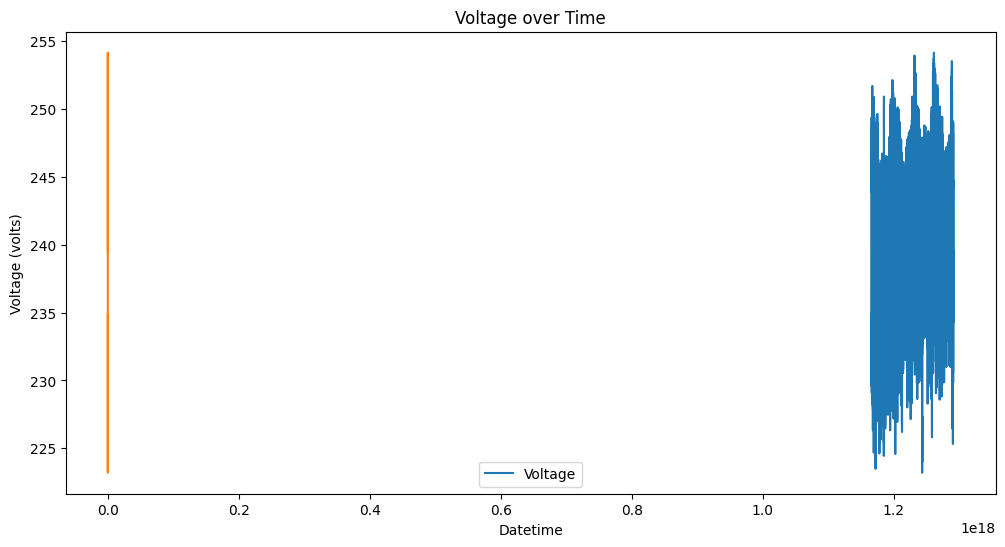

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Datetime'], df['Voltage'], label='Voltage')
plt.plot(df['Voltage'].values)
plt.title('Voltage over Time')
plt.xlabel('Datetime')
plt.ylabel('Voltage (volts)')
plt.legend()
plt.show()

In [7]:
# Create lag features (previous energy consumption values)
df['Global_active_power_lag1'] = df['Global_active_power'].shift(1)
df['Global_active_power_lag24'] = df['Global_active_power'].shift(24)

# Drop rows with NaN values due to the lag
df = df.dropna()

# Display the new features
df[['Global_active_power', 'Global_active_power_lag1', 'Global_active_power_lag24']].head()


,Global_active_power,Global_active_power_lag1,Global_active_power_lag24
24,4.474,5.174,4.216
25,3.248,4.474,5.360
26,3.236,3.248,5.374
27,3.228,3.236,5.388
28,3.258,3.228,3.666


In [8]:
# Define features (X) and target variable (y)
X = df[['Global_active_power_lag1', 'Global_active_power_lag24']]
y = df['Global_active_power']

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the first few rows of X_train and y_train
X_train.head(), y_train.head()

(         Global_active_power_lag1  Global_active_power_lag24
 535440                      0.840                      0.546
 1446392                     0.264                      0.344
 748192                      3.482                      0.594
 152084                      4.560                      1.628
 2008198                     2.038                      2.516,
 535440     0.838
 1446392    0.264
 748192     3.464
 152084     6.384
 2008198    2.024
 Name: Global_active_power, dtype: float64)

In [9]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")


Mean Squared Error: 0.08722199347521113
Root Mean Squared Error: 0.29533369850934915


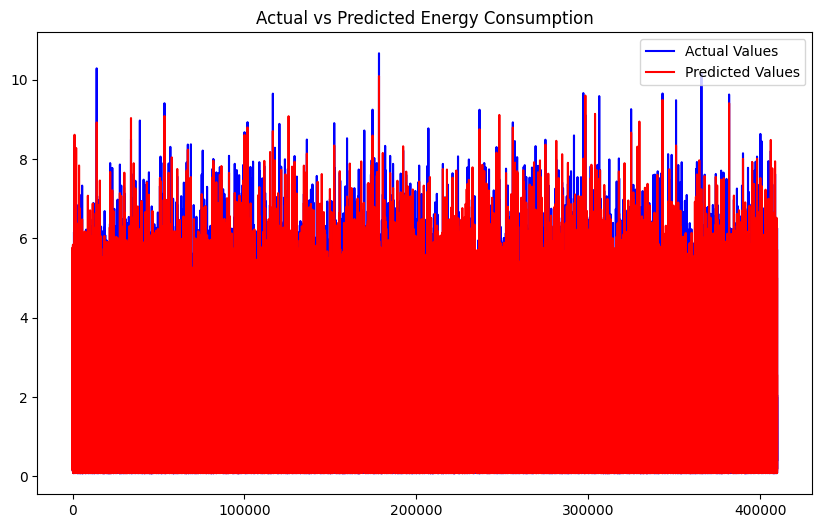

In [ ]:
# Plot Actual vs. Predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Values', color='blue')
plt.plot(y_pred, label='Predicted Values', color='red')
plt.legend()
plt.title('Actual vs Predicted Energy Consumption')
plt.show()

In [ ]:
print(df.columns)

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Datetime'],
      dtype='object')


In [ ]:
#Artificial Neural Network (ANN)
from tensorflow import keras
import numpy as np

# Dummy Data (Replace with actual values)
X_train, y_train = np.random.rand(100, 3), np.random.rand(100)

# Build & Train Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2975
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1592  
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1016 
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1035 
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1074 
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0999 
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0960 
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0910 
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0856 
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0910 


In [ ]:
#Artificial Neural Network (ANN)
from tensorflow import keras

# Build & Train Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Make Predictions
y_pred = model.predict(X_test)
print("ANN Predictions:", y_pred.ravel())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
ANN Predictions: [0.05382659 0.3050298  0.49866068 0.69229144 0.8859219 ]


In [ ]:
#GaussianProcessRegresso
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Dummy Data
X_train = np.random.rand(20, 1) * 10  # 20 samples, 1 feature
y_train = np.sin(X_train).ravel() + np.random.normal(0, 0.1, X_train.shape[0])  # Add noise

# Define kernel & train model
kernel = C(1.0) * RBF(length_scale=1.0)
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
model.fit(X_train, y_train)

# Make Predictions
X_test = np.linspace(0, 10, 5).reshape(-1, 1)  # Test Data (5 points)
y_pred, sigma = model.predict(X_test, return_std=True)

# Print Results
print("Predictions:", y_pred)
print("Uncertainty (Standard Deviation):", sigma)


Predictions: [0. 0. 0. 0. 0.]
Uncertainty (Standard Deviation): [0.81271047 0.81271047 0.81271047 0.81271047 0.81271047]


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
#k-Nearest Neighbors (k-NN)
from sklearn.neighbors import KNeighborsRegressor

# Train Model
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
print("k-NN Predictions:", y_pred)


k-NN Predictions: [ 0.08240328  0.08240328 -0.70765184  0.81307967  0.19123701]


In [ ]:
#Linear Regression (LR)
from sklearn.linear_model import LinearRegression

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
print("LR Predictions:", y_pred)


LR Predictions: [0.09665543 0.17329864 0.24994184 0.32658505 0.40322825]


In [ ]:
#Random Forest (RF)
from sklearn.ensemble import RandomForestRegressor

# Train Model
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
print("RF Predictions:", y_pred)


RF Predictions: [ 0.84844081  0.74079928 -1.05732442  0.9231762  -0.09531686]


In [ ]:
#Support Vector Machine (SVM)
from sklearn.svm import SVR

# Train Model
model = SVR()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)
print("SVM Predictions:", y_pred)


SVM Predictions: [ 0.68030951  0.45329304 -0.94404879  0.8881112  -0.2293453 ]
